# Project 4: Advanced Lane Lines
Andrew Burruss

3rd Submission

Udacity CarND: Term 1

## Pre-Processing Steps

    Camera calibration
    Distortion correction
    Color/gradient threshold
    Perspective transform

## Analysis Steps

    Detect lane lines
    Determine the lane curvature

In [1]:
## Latest edit: Mar. 15, 2018
## 3rd revision
## Reference Line class in Line.py

## Pre-processing
## Camera calibration
# source files
# /camera_cal/calibration*.jpg
# returns object points and image points
# fixed board size bug: Dec 18

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# uncomment when class def and methods are completed
#from Line import Line

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')


# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

Text(0.5,1,'Undistorted Image')

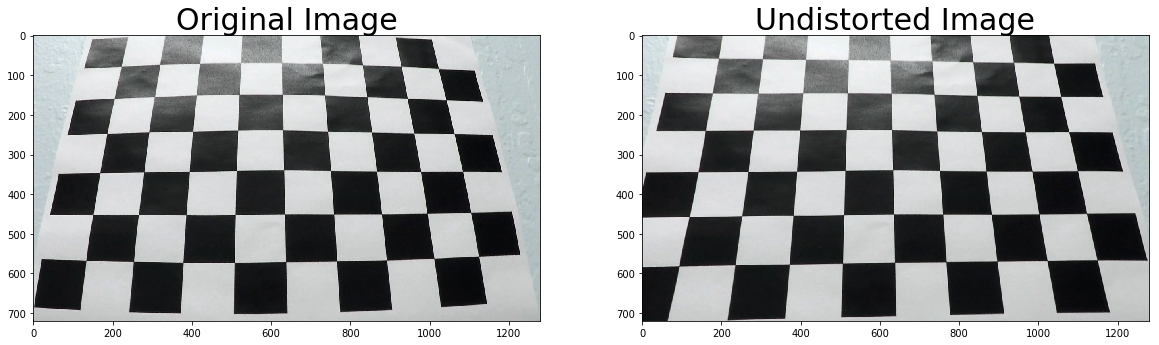

In [2]:
# pass object points and image points to camera calibration
# calibrate camera and output sample img
import pickle
%matplotlib inline

# Test undistortion on an image from calibration set
img = cv2.imread('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) ) 
# break here
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

True
(54, 1, 2)


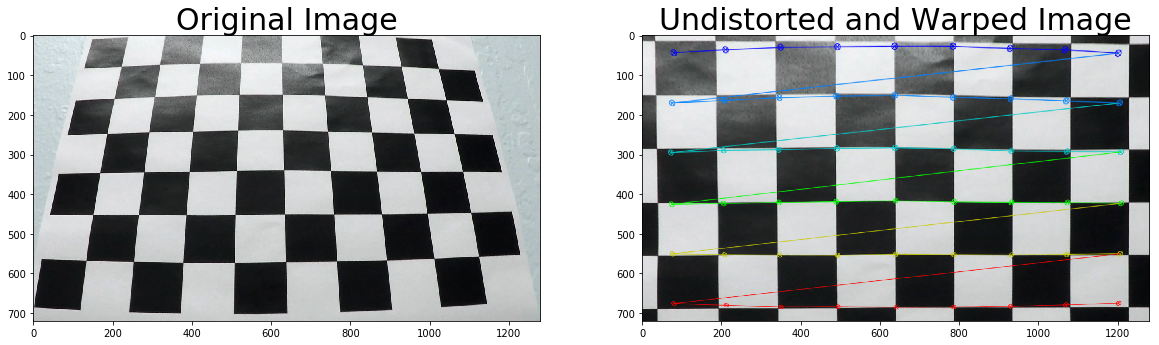

In [4]:
## Distortion correction
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('camera_cal/calibration3.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(img, (nx, ny), None)
    print(ret)
    print(corners.shape)

    if ret == True:
        # If we found corners, draw them
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        offset_x = 80 # offset for dst points
        offset_y = 45
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # source points: outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # destination points
        dst = np.float32([[offset_x, offset_y], [img_size[0]-offset_x, offset_y], 
                                     [img_size[0]-offset_x, img_size[1]-offset_y], 
                                     [offset_x, img_size[1]-offset_y]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

# we will frequently compare processed images to their original input
def display2(img1, img2, title1=None, title2=None):
    # depends on %matplotlib inline
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1) # raw img
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(img2, cmap='gray') # processed img
    ax2.set_title(title2, fontsize=30)

display2(img,top_down,'Original Image','Undistorted and Warped Image')

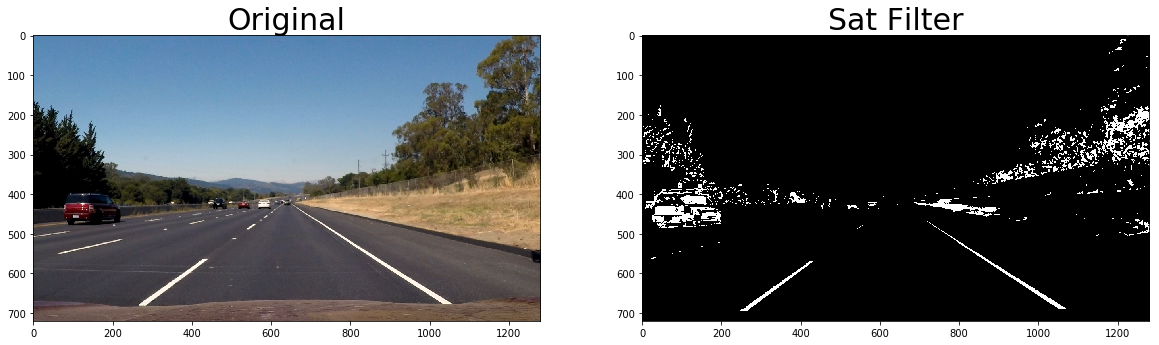

In [6]:
image = mpimg.imread('test_images/straight_lines2.jpg')

#  color filter threshold test
# HLS color space
# saturation channel picks up both lane lines

def color_filter_sat(img, s_thresh=(128, 255)):
    img = np.copy(img)
    
    # undistort
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert to HLS color space and separate the H, L, and S channels
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Threshold color channel: yellow
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    return s_binary


test_img = color_filter_sat(image)

# Plot the result
display2(image, test_img, 'Original', 'Sat Filter')

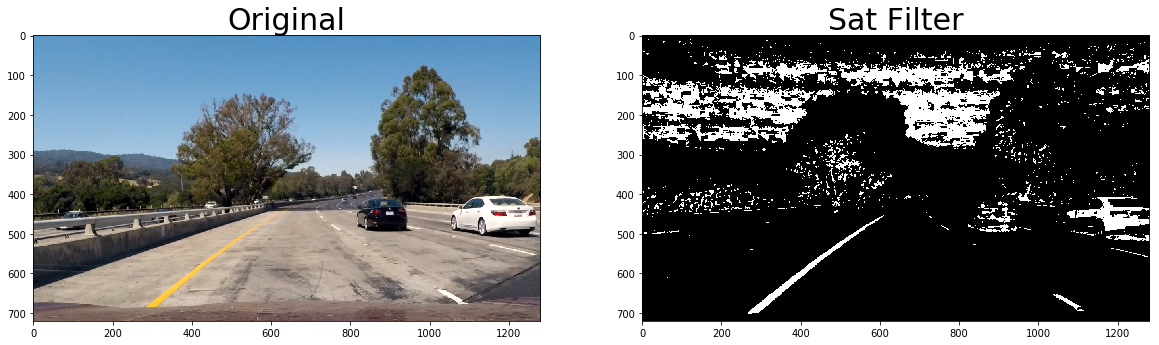

In [7]:
# color_filter_sat test on curved road image
image = mpimg.imread('test_images/test1.jpg')

result2 = color_filter_sat(image)

# Plot the result
display2(image, result2, 'Original', 'Sat Filter')

(1280, 720)


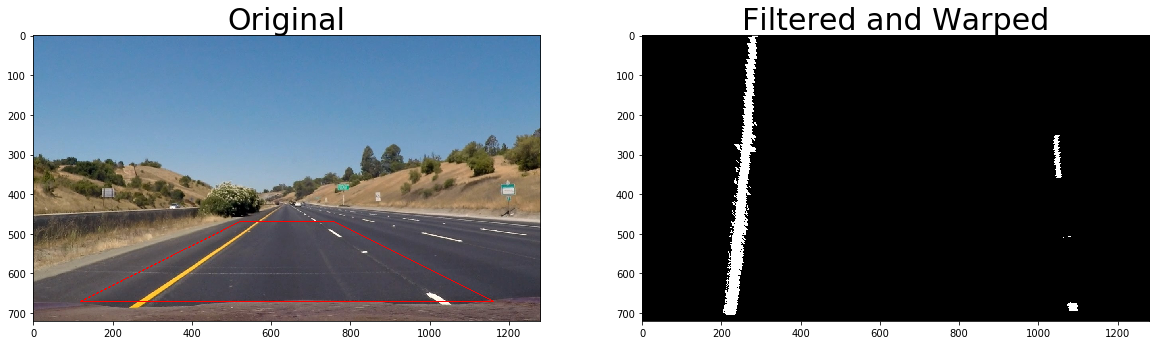

In [8]:
## Perspective transform
# overlay trapezoid region outside lane lines

image = mpimg.imread('test_images/straight_lines1.jpg')
img_size = (image.shape[1], image.shape[0])
print(img_size)
# add trapezoid to image
# will be used as guidelines for warp transform
trap_points = np.array([[760,470],[1160,670],[120,670],[520,470]])
dst = [[1240,40],
        [1240,680],
        [40,680],
        [40,40]]

def warp(img, src_pts, dst_pts):
    # Define calibration box in source (orig) and destination (warped) coords
    img_size = (img.shape[1], img.shape[0])
    # four source coords
    src = np.float32([src_pts])

    # four warped coords
    dst = np.float32([dst_pts])

    # Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dst)

    # Compute the inverse perspective transform:
    # same util: just reverse args: square matrix invertible transform
    Minv = cv2.getPerspectiveTransform(dst, src)

    return M, Minv


piped_img = color_filter_sat(image)

M, Minv = warp(piped_img, trap_points, dst)

# Warp an image using the perspective transform, M:
warped = cv2.warpPerspective(piped_img, M, img_size, flags=cv2.INTER_NEAREST)

image = cv2.polylines(image, np.int32([trap_points]), True, (255,0,0),2)

# Plot the result
display2(image, warped, 'Original', 'Filtered and Warped')

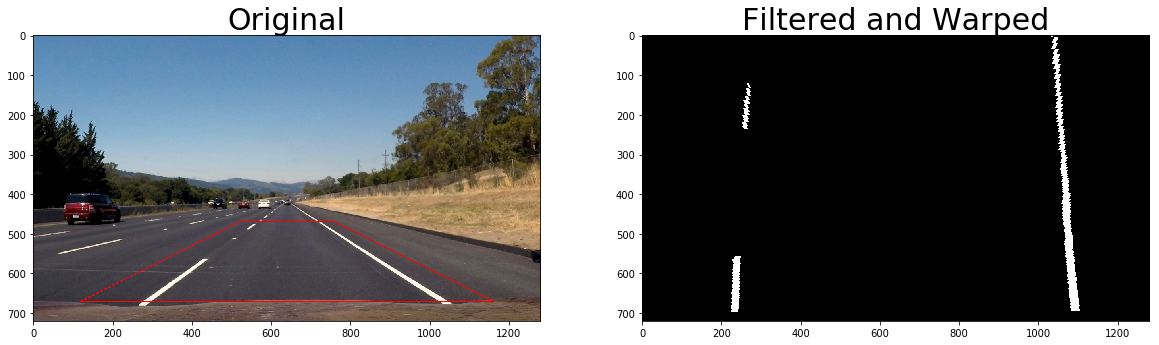

In [9]:
# reset source image
# test warp on other straight line image
image = mpimg.imread('test_images/straight_lines2.jpg')
piped_img = color_filter_sat(image)

# unused
#uprights = np.array([[1120,10],[1120,710],[220,710],[220,10]])

M, Minv = warp(piped_img, trap_points, dst)

# Warp an image using the perspective transform, M:
warped = cv2.warpPerspective(piped_img, M, img_size, flags=cv2.INTER_NEAREST)


image = cv2.polylines(image, np.int32([trap_points]), True, (255,0,0),2)

# Plot the result
display2(image, warped, 'Original', 'Filtered and Warped')

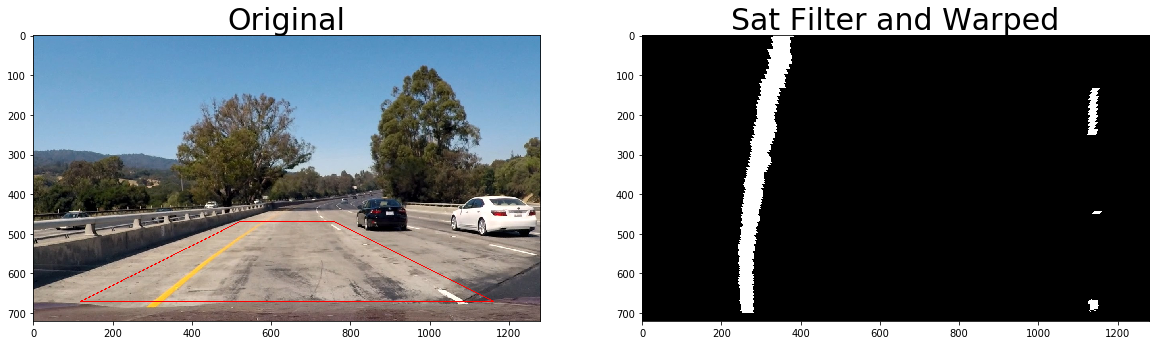

In [10]:
# reset source image
# test warp on other curved road image
image = mpimg.imread('test_images/test1.jpg')
piped_img = color_filter_sat(image)
M, Minv = warp(piped_img, trap_points, dst)

# Warp an image using the perspective transform, M:
warped = cv2.warpPerspective(piped_img, M, img_size, flags=cv2.INTER_NEAREST)

image = cv2.polylines(image, np.int32([trap_points]), True, (255,0,0),2)

# Plot the result
display2(image, warped, 'Original', 'Sat Filter and Warped')

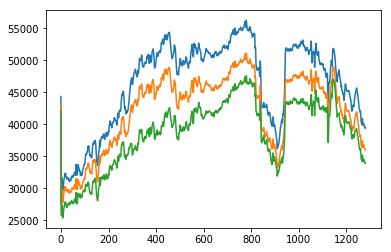

In [11]:
# histogram visual
image = mpimg.imread('test_images/test1.jpg')

histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

(720, 0)

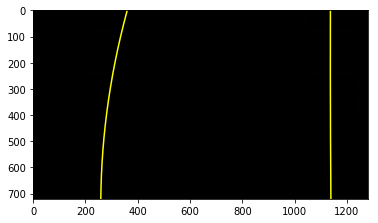

In [13]:
# histogram peak search for lane lines
# source image is same as two cells above
# sliding windows

# reset source image
image = mpimg.imread('test_images/test1.jpg')
piped_img = color_filter_sat(image)

M, Minv = warp(piped_img, trap_points, dst)

# Warp an image using the perspective transform, M:
warped = cv2.warpPerspective(piped_img, M, img_size, flags=cv2.INTER_NEAREST)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped, warped, warped))*255

# Take a histogram of the bottom half of the image
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    
    ################################ sliding windows
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3)
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    ################################ sliding windows
    

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

############################### Visualization
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]   #red
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255] #blue
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow') #plot of detected lines
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

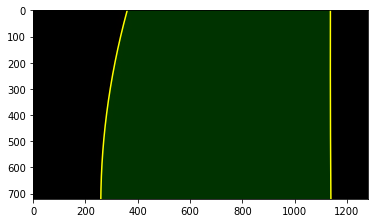

In [14]:
# shaded detected lane

############################### Visualization

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped, warped, warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

center_line_pts = np.hstack((left_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
#cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([center_line_pts]), (0,255, 0))

result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [15]:
# Radius of Curvature (meters)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/900 # meters per pixel in x dimension

# gets lefty, x and righty, x from last cell
y_eval = np.max(ploty)

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# read out coefficients
print('left fit coefficients', left_fit_cr)
print('right fit coefficients', right_fit_cr)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Now our radius of curvature is in meters
print('left curve radius', '{0:.{1}f}'.format(left_curverad, 4), 'm')
print('right curve radius', '{0:.{1}f}'.format(right_curverad, 4), 'm')

left fit coefficients [ 4.30764439e-04 -2.67348442e-02  1.47912879e+00]
right fit coefficients [ 1.75062312e-05 -2.69332191e-04  4.67338903e+00]
left curve radius 1160.7287 m
right curve radius 28561.2848 m


In [16]:
# Left of center (m)

# calculated lane center is mean of two detected lane lines
calc_center = (leftx[0] + rightx[0])/2

# left of center
# assume camera is centered between wheels
LOC = (calc_center - 640)*xm_per_pix

#output
print('vehicle is ', '{0:.{1}f}'.format(LOC, 4), ' (m) left of center')

vehicle is  0.2035  (m) left of center


undistorted
(720, 1280, 3)
array <class 'numpy.ndarray'>
element <class 'numpy.uint8'> 97
unwarped
(720, 1280, 3)
array <class 'numpy.ndarray'>
element <class 'numpy.uint8'> 0


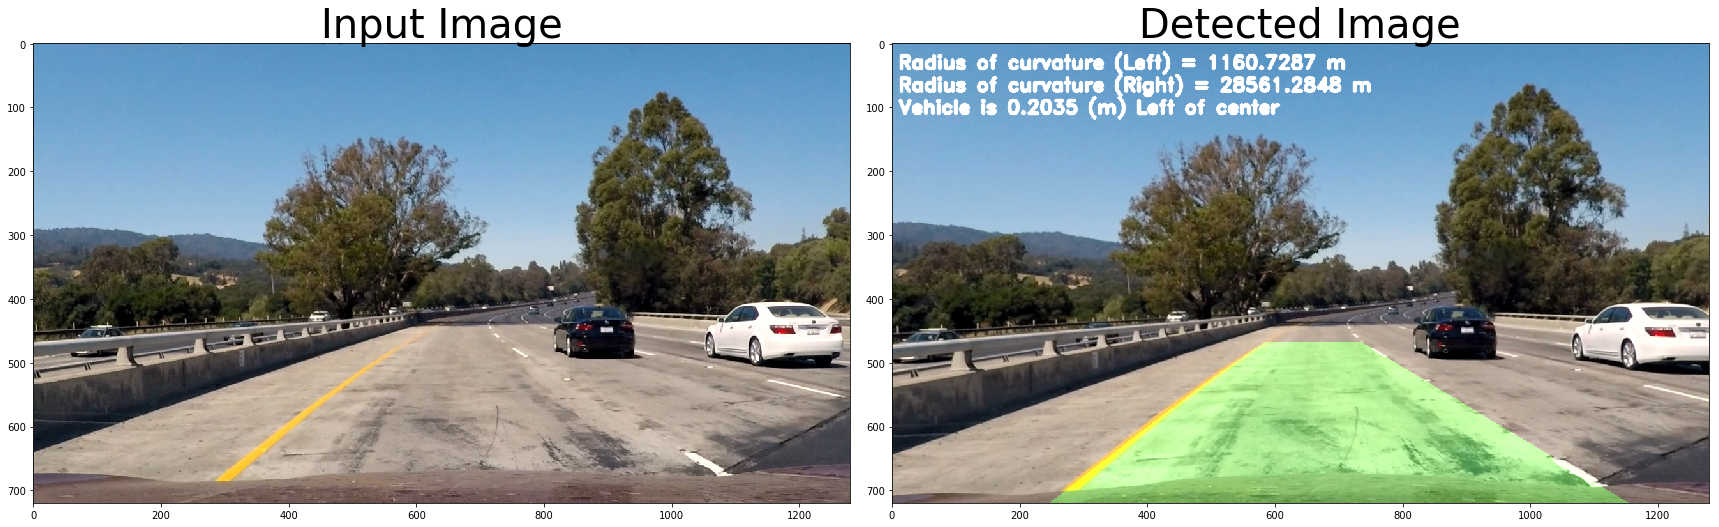

In [17]:
# test overlay
# test unwarp
# put text on image
font = cv2.FONT_HERSHEY_DUPLEX
unwarped_2 = cv2.warpPerspective(window_img, Minv, img_size, flags=cv2.INTER_NEAREST)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

# image is test1.jpg
ax1.imshow(image)
ax1.set_title('Input Image', fontsize=40)

# undistort image before applying detected lane
undistorted = cv2.undistort(image, mtx, dist, None, mtx)
# cast unwarped_2 data as integer type
unwarped_2 = unwarped_2.astype(np.uint8, copy=False)
print('undistorted')
print(undistorted.shape)
print('array', type(undistorted))
print('element', type(undistorted[0][0][0]), undistorted[0][0][0])
print('unwarped')
print(unwarped_2.shape)
print('array', type(unwarped_2) )
print('element', type(unwarped_2[0][0][0]), unwarped_2[0][0][0])


mrg_dst = np.zeros_like(undistorted)

cv2.addWeighted(undistorted, 1,unwarped_2, 0.3, 0, mrg_dst )

# put Text
cv2.putText(mrg_dst, 'Radius of curvature (Left) = %.4f m' % (left_curverad), (10, 40), font, 1, (255, 255, 255), 3, cv2.LINE_AA)

cv2.putText(mrg_dst, 'Radius of curvature (Right) = %.4f m' % (right_curverad), (10, 75), font, 1, (255, 255, 255), 3, cv2.LINE_AA)

cv2.putText(mrg_dst, 'Vehicle is %.4f (m) Left of center' % (LOC),(10, 110), font, 1, (255, 255, 255), 3, cv2.LINE_AA)
ax2.imshow(mrg_dst)
ax2.set_title('Detected Image', fontsize = 40)

plt.show()
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# define lane detection of histogram peaks: sliding windows
# image is original input image
# warped binary image is "warped"

def sliding_windows(image, warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &
                           (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ###################################### Visualization
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]   #red
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255] #blue
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    center_line_pts = np.hstack((left_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([center_line_pts]), (0,255, 0))
    '''
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    '''
    return ploty, lefty, leftx, righty, rightx, window_img

In [ ]:
# define lane detection of histogram peaks/ optimize with 'left_fit', 'right_fit' seed values

# image is original input image
# warped binary image is "warped"

def recur_windows(image, warped):
    # histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    # plt.plot(histogram)

    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin))
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin))
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin))) 

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ###################################### Visualization
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]   #red
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255] #blue
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    center_line_pts = np.hstack((left_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([center_line_pts]), (0,255, 0))
    '''
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    '''
    return ploty, lefty, leftx, righty, rightx, window_img

In [ ]:
# lane detection pipeline: uses class definition

# winCount is number of rectangular slices in each still image (of video)

def pipeline_recur(img, winCount, storedLane):
    # img processing
    

    # create Line instance
    # detected = False

    
    # recursive window search
    # if new: sliding windows
    # if not detected: sliding windows
    # else if detected: use recur windows
    # update Line
    
    
    # validate Line data
    if winCount == 0:
        storedLane = newLane
        winCount += 1
    else if (np.fabs(storedLane.left_fit_cr - newLane.left_fit_cr) < 0.5 and 
            np.fabs(storedLane.right_fit_cr - newLane.right_fit_cr) < 0.5 and
            np.abs(storedLane.left_curverad - newLane.left_curverad) < 0.5 and
            np.abs(storedLane.right_curverad - newLane.right_curverad) < 0.5):
        storedLane = newLane
        winCount += 1
    else:
        winCount += 1
    
    # combine image 'result'
    # read computed params from storedLane.param
    
    # return StoredLane, result
    
    pass    
    

In [ ]:
# define lane detection pipeline: sliding windows lane detection

def pipeline_sliding(image):
    img_size = (image.shape[1], image.shape[0])
    # color gradient
    cgrad_image = color_filter_sat(image)
    
    # find warp matrix and inverse
    M, Minv = warp(cgrad_image)
    # apply
    warped = cv2.warpPerspective(cgrad_image, M, img_size, flags=cv2.INTER_NEAREST)
    
    # lane detection
    ploty, lefty, leftx, righty, rightx, window_img = sliding_windows(image, warped)
    
    # Radius of Curvature (meters)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # calculated lane center is mean of two detected lane lines
    calc_center = (leftx[0] + rightx[0])/2
    # left of center: assume camera is centered between wheels
    LOC = (calc_center - 640)*xm_per_pix
    
    unwarped = cv2.warpPerspective(window_img, Minv, img_size, flags=cv2.INTER_NEAREST)
    # print(unwarped.shape())
    # undistort image
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    # print(undist.shape())
    unwarped = unwarped.astype(np.uint8, copy=False)
    result = cv2.addWeighted(undist, 1, unwarped, 0.3, 0)
    # put text on image
    font = cv2.FONT_HERSHEY_DUPLEX
    # put Text
    cv2.putText(result, 'Radius of curvature (Left) = %.4f m' % (left_curverad), (10, 40), font, 1, (255, 255, 255), 3, cv2.LINE_AA)
    cv2.putText(result, 'Radius of curvature (Right) = %.4f m' % (right_curverad), (10, 75), font, 1, (255, 255, 255), 3, cv2.LINE_AA)
    cv2.putText(result, 'Vehicle is %.4f (m) Left of center' % (LOC),(10, 110), font, 1, (255, 255, 255), 3, cv2.LINE_AA)
    
    
    return result

## Analysis
## Detect Lane Lines

In [ ]:
## Detect lane lines: each (2) straight_lines*.jpg images

# analyze
image = mpimg.imread('test_images/straight_lines1.jpg')
result = pipeline_sliding(image)

# output to screen
plt.imshow(result)

# save as processed image
cv2.imwrite('output_images/Processed_straight_lines1.jpg', result)

In [ ]:
# repeat for second image

image2 = mpimg.imread('test_images/straight_lines2.jpg')
result2 = pipeline_sliding(image2)

# output to screen
plt.imshow(result2)

# save as processed image
cv2.imwrite('output_images/Processed_straight_lines2.jpg', result2)

In [ ]:
## Detect lane lines: each (6) test*.jpg images

for i in range(6):
    image = mpimg.imread('test_images/test'+str(i+1)+'.jpg')
    result = pipeline_sliding(image)
    cv2.imwrite('output_images/Processed_test'+str(i+1)+'.jpg', result)

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
# subclip for testing
video_output = 'output_images/processed_subclip_video.mp4'
subclip = VideoFileClip("project_video.mp4").subclip(40, 51)
out_clip = subclip.fl_image(pipeline_sliding) #pipeline_recur
%time out_clip.write_videofile(video_output, audio=False)

In [ ]:
video_output = 'output_images/processed_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(pipeline_sliding) 
%time out_clip.write_videofile(video_output, audio=False)

In [ ]:
video_output = 'output_images/processed_challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
out_clip = clip1.fl_image(pipeline_sliding) 
%time out_clip.write_videofile(video_output, audio=False)

In [ ]:
video_output = 'output_images/processed_harder_challenge_video.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
out_clip = clip1.fl_image(pipeline_sliding) 
%time out_clip.write_videofile(video_output, audio=False)

## Sources

https://github.com/udactity/CarND-Advanced-Lane-Lines
    
https://github.com/udactity/CarND-Camera-Calibration

Udacity CarND: Project 4: Advanced Lane Lines

Labs 17, 30, 33, 34, 35

Slack https://carnd.slack.com
    
    #p-advanced-lane-lines channel